## Step 1: Reading the data

We begin by downloading the data.

We read the data from the train and test datasets and set the Y values to the income (`target`), and the rest in the X values.

In [ ]:
!wget https://www.cse.chalmers.se/~richajo/dit866/data/adult_test.csv
!wget https://www.cse.chalmers.se/~richajo/dit866/data/adult_train.csv

In [ ]:
import pandas as pd
# Read the CSV file.
test = pd.read_csv('adult_test.csv')
train = pd.read_csv('adult_train.csv')

cols = ["age","workclass","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","target"]
test = test[cols]
train = train[cols]
X_test = test.drop("target", axis=1)
X_train = train.drop("target", axis=1)
Y_test = test["target"]
Y_train = train["target"]

In [ ]:
X_test.head()

### Step 2: Enconding the features as numbers

We now use one-hot encoding of the features to convert them to numerical values so we can work with them in scikit.

In [ ]:
x_test_dict = X_test.to_dict('records')
x_train_dict = X_train.to_dict("records")
y_test_dict = Y_test.to_dict()
y_train_dict = Y_train.to_dict()

Now we encode the dicts

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
dv = DictVectorizer()
X_train_encoded = dv.fit_transform(x_train_dict)
# Y_train_encoded = dv.fit_transform(y_train_dict)

X_test_encoded = dv.transform(x_test_dict)
# Y_test_encoded = dv.transform(y_test_dict)
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

In [ ]:
import sklearn.ensemble as ensemble
from sklearn.model_selection import cross_val_score
import numpy as np

gb_clf = ensemble.GradientBoostingClassifier(max_depth=10)
gb_cross_val = cross_val_score(gb_clf, X_train_encoded, Y_train_encoded)
print(np.mean(gb_cross_val))

### Step 3: Combining the steps

Now it is time to do some more preprocessing, and we make a pipeline consisting of our vectorization followed by a RandomForestClassifier.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
  DictVectorizer(),
  DecisionTreeClassifier ()
)

pipeline.fit(x_train_dict, Y_train_encoded)

In [ ]:
from sklearn.model_selection import cross_val_score


scores = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
print("Cross-validation scores:", scores)
print("Average score:", np.mean(scores))

## Task 2: Decision trees and random forests

We now investigate the performance of classifiers with regards to the maxmimum depth of the tree.

We test for depths `1..12` with a pipeline using a `DecisionTreeClassifier`.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

total_scores = []
for i in range(1, 12):
  pipeline = make_pipeline(
    DictVectorizer(),
    DecisionTreeClassifier(max_depth=i)
  )
  pipeline.fit(x_train_dict, Y_train_encoded)
  scores = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
  total_scores.append({"scores": scores, "avg_score": np.mean(scores)})


print(total_scores)

We see that it keeps increasing in performance until around max_depth=6/7, then it probably overfits on the training data and it performs worse on the test set.

In [ ]:
import matplotlib.pyplot as plt
# Extracting average scores and depths
avg_scores = [d['avg_score'] for d in total_scores]
depths = range(1, len(avg_scores) + 1)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(depths, avg_scores, marker='o')
plt.title("Average Cross-Validation Score vs. Tree Depth")
plt.xlabel("Max Depth of Decision Tree")
plt.ylabel("Average Cross-Validation Score")
plt.xticks(depths)
plt.grid(True)
plt.show()

### Underfitting and overfitting in random forest classifiers

We now will perform the same experiment as the one above, but look at a `RandomForestClassifier` with regards to the size of the ensemble, i.e., the `n_estimators` parameter

In [28]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

total_scores = []

pipeline = make_pipeline(
  DictVectorizer(),
  RandomForestClassifier(n_estimators=1, n_jobs=-1)
)
pipeline.fit(x_train_dict, Y_train_encoded)
scores = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
total_scores.append({"scores": scores, "avg_score": np.mean(scores)})

for i in range(10, 301, 10):
  pipeline = make_pipeline(
    DictVectorizer(),
    RandomForestClassifier(n_estimators=i, n_jobs=-1)
  )
  pipeline.fit(x_train_dict, Y_train_encoded)
  scores = cross_val_score(pipeline, x_test_dict, Y_test_encoded, cv=5)
  total_scores.append({"scores": scores, "avg_score": np.mean(scores)})

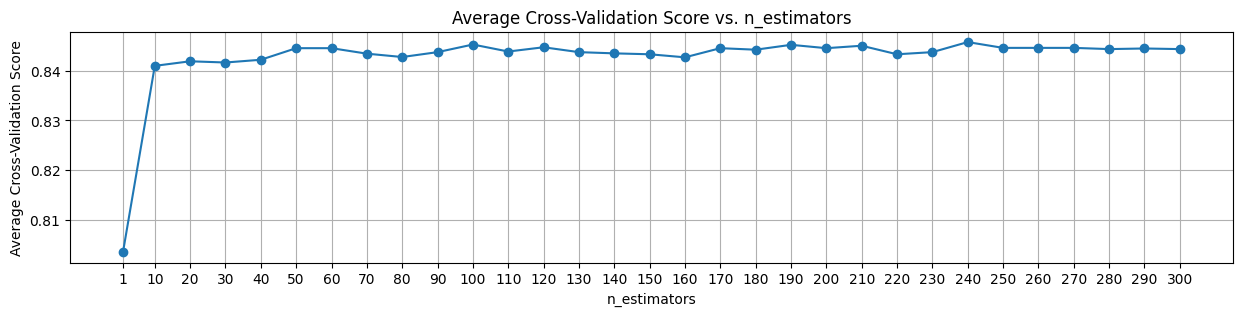

In [38]:
# Extracting average scores and depths
avg_scores = [d['avg_score'] for d in total_scores]
depths = [i * 10 if i != 0 else 1 for i in range(0, len(avg_scores))]

# Plotting
plt.figure(figsize=(15, 3))
plt.plot(depths, avg_scores, marker='o')
plt.title("Average Cross-Validation Score vs. n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Average Cross-Validation Score")
plt.xticks(depths)
plt.grid(True)
plt.show()


What's the difference between the curve for a decision tree and for a random forest with an ensemble size of 1, and why do we see this difference?

What happens with the curve for random forests as the ensemble size grows?
As the ensemble size grows, the curve goes towards a more stable value and hovers around that more tightly.

What happens with the best observed test set accuracy as the ensemble size grows?
The best observed test set accuracy is when the ensemble size is not that big.

What happens with the training time as the ensemble size grows?

The training time increases linearly as the the ensemble size grows.

## Task 3

We extra

In [41]:
dict_vectorizer = pipeline.steps[0][1]
features_names = dict_vectorizer.feature_names_

clf = pipeline.steps[1][1]
feature_importance = clf.feature_importances_

features = list(zip(features_names, feature_importance))
sorted_features = sorted(features, key=lambda x: x[1], reverse=True)

for feature in sorted_features:
  print(feature)

('age', 0.22650482335372668)
('hours-per-week', 0.11405905427690158)
('capital-gain', 0.10741326458724008)
('education-num', 0.0679170161418503)
('marital-status=Married-civ-spouse', 0.06431271127986277)
('relationship=Husband', 0.04236598787199315)
('capital-loss', 0.03553908447317525)
('marital-status=Never-married', 0.027952251964743116)
('occupation=Exec-managerial', 0.0192584997053966)
('occupation=Prof-specialty', 0.015456843855704125)
('relationship=Not-in-family', 0.012571910334762619)
('education=Bachelors', 0.012187495326396939)
('workclass=Private', 0.0114032721696194)
('relationship=Wife', 0.010899317538153772)
('relationship=Own-child', 0.009942112381965266)
('sex=Female', 0.009501746577066688)
('sex=Male', 0.009277167656400152)
('workclass=Self-emp-not-inc', 0.009243728259439902)
('education=HS-grad', 0.008177275848428407)
('education=Masters', 0.008168826576437744)
('occupation=Other-service', 0.0074759346999885125)
('occupation=Sales', 0.007294930212582272)
('occupation